In [1]:
# Downloading the data: Car price
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-09 10:33:15--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1,41M  --.-KB/s    in 0,1s    

2023-10-09 10:33:15 (13,5 MB/s) - ‘data.csv.1’ saved [1475504/1475504]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression

In [3]:
# Selecting the columns to be used
car_df = pd.read_csv("data.csv")

print(car_df.columns)
display(car_df.head(2))

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


In [4]:
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Size', 'Vehicle Style',
           'highway MPG', 'city mpg', 'MSRP']

In [5]:
car_df2 = car_df.copy()
car_df2 = car_df2[columns]
car_df2.columns = car_df2.columns.str.replace(" ", "_").str.lower()

In [6]:
car_df2.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_size', 'vehicle_style', 'highway_mpg',
       'city_mpg', 'msrp'],
      dtype='object')

In [7]:
cols = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_size', 'vehicle_style', 'highway_mpg',
       'city_mpg']

In [8]:
car_df2[cols] = car_df2[cols].fillna(0) 

In [9]:
# Making price binary
mean_price = car_df2["msrp"].mean()

above_average = car_df2["msrp"].map(lambda value_: 1 if value_ >= mean_price else 0)

car_df3 = car_df2.copy()
car_df3["above_average"] = above_average

del car_df3["msrp"]

In [10]:
full_train_df, test_df = train_test_split(car_df3, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)

In [11]:
m_total = len(car_df3)

train_df.shape[0]/m_total, test_df.shape[0]/m_total, val_df.shape[0]/m_total

(0.5999664260533826, 0.2000167869733087, 0.2000167869733087)

In [12]:
# ROC AUC feature importance
train_df.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_size,vehicle_style,highway_mpg,city_mpg,above_average
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,Midsize,4dr SUV,28,27,1
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Large,Sedan,30,18,0


ROC AUC could also be used to evaluate feature importance of numerical variables.

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
num_cols = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

y = train_df["above_average"].values
for col in num_cols:
    x = train_df[col].values
    
    auc = roc_auc_score(y, x)
    if auc < 0.5:
        auc = roc_auc_score(y, -x)

    
    print(f"AUC of ({col}, above_average): {auc}")
    print()

AUC of (year, above_average): 0.687551492804683

AUC of (engine_hp, above_average): 0.9171031265539011

AUC of (engine_cylinders, above_average): 0.766116490165669

AUC of (highway_mpg, above_average): 0.6330587871772013

AUC of (city_mpg, above_average): 0.6734244643245233



In [14]:
# Training the model

y_train = train_df["above_average"]
y_val = val_df["above_average"]

del train_df["above_average"]
del val_df["above_average"]

In [15]:
train_df.head(2)

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_size,vehicle_style,highway_mpg,city_mpg
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,Midsize,4dr SUV,28,27
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Large,Sedan,30,18


In [16]:
cat_cols = ['make', 'model', 'engine_hp', 'transmission_type', 'vehicle_size', 'vehicle_style']
num_cols = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

train_dict = train_df[cat_cols + num_cols].to_dict(orient='records')
val_dict = val_df[cat_cols + num_cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

/tmp/ipykernel_860639/1334777096.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  train_dict = train_df[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/1334777096.py:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  val_dict = val_df[cat_cols + num_cols].to_dict(orient='records')


In [17]:
# Training a Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
above_avg = y_pred > 0.5

val_auc = round(roc_auc_score(y_val, above_avg), 3)
print(f"val_auc: {val_auc}")

val_auc: 0.918


In [18]:
# Precision and Recall

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

scores_df = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

scores_df['tpr'] = scores_df.tp / (scores_df.tp + scores_df.fn)
scores_df['fpr'] = scores_df.fp / (scores_df.fp + scores_df.tn)

scores_df["precision"] = scores_df.tp / (scores_df.tp + scores_df.fp)
scores_df["recall"] = scores_df.tp / (scores_df.tp + scores_df.fn)

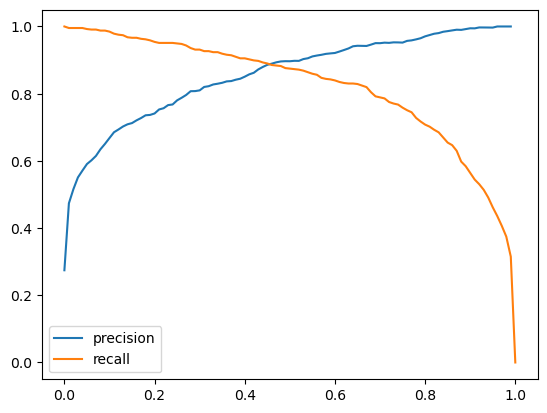

In [19]:
plt.plot(scores_df.threshold, scores_df['precision'], label='precision')
plt.plot(scores_df.threshold, scores_df['recall'], label='recall')
plt.legend()

In [20]:
# F1 Score
scores_df["f1_score"] = 2 * (scores_df.precision * scores_df.recall) / (scores_df.precision + scores_df.recall)

In [21]:
scores_df = scores_df.iloc[:-1]

In [22]:
np.argmax(scores_df.f1_score.values)

48

In [23]:
scores_df.iloc[np.argmax(scores_df.f1_score.values)]

threshold       0.480000
tp            577.000000
fp             67.000000
fn             77.000000
tn           1662.000000
tpr             0.882263
fpr             0.038751
precision       0.895963
recall          0.882263
f1_score        0.889060
Name: 48, dtype: float64

In [24]:
# K Fold Cross-Validation

def train(df_train, y_train, C=1.0):
    dicts = df_train[cat_cols + num_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[cat_cols + num_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [25]:
n_splits = 5

for C in [1.0]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(full_train_df):
        df_train = full_train_df.iloc[train_idx]
        df_val = full_train_df.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))



/tmp/ipykernel_860639/2978757284.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df_train[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/2978757284.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/2978757284.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df_train[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/2978757284.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/2978757284.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df_train[cat_cols + num_cols].to_dict(orient='records')
/tmp/ipykernel_860639/2978757284.py:15: UserWarning: DataFrame columns are not unique, some columns 

C=1.0 0.981 +- 0.003


/tmp/ipykernel_860639/2978757284.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dicts = df[cat_cols + num_cols].to_dict(orient='records')


In [26]:
import warnings
warnings.filterwarnings("ignore")

# Hyperparameter tuning
n_splits = 5

for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(full_train_df):
        df_train = full_train_df.iloc[train_idx]
        df_val = full_train_df.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))



C=0.01 0.952 +- 0.002
C=0.1 0.973 +- 0.002
C=0.5 0.979 +- 0.004
C=10 0.982 +- 0.003
